<a href="https://colab.research.google.com/github/PaSathees/my-ai-courses/blob/main/3.%20UDEMY-PYTORCH/2.%20PyTorch%20Neural%20Network%20Classification/PyTorch_Practice_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [2]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [3]:
# make dataframe
import pandas as pd
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [4]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

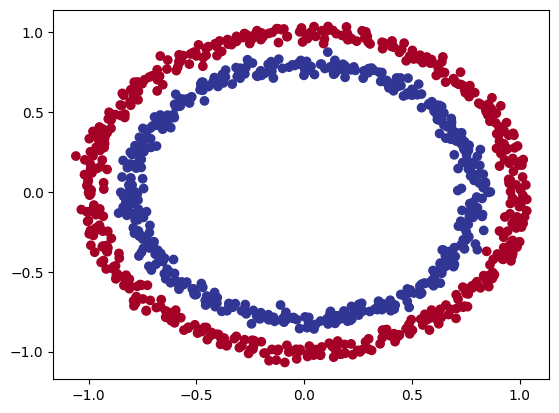

In [5]:
# visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X[0].shape, y[0].shape

((2,), ())

In [8]:
# Turn into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [10]:
import torch
from torch import nn

# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
class CircleModelV0(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
untrained_preds = model_0(X_test.to(device))

In [14]:
untrained_preds[:10]

tensor([[-5.7242e-01],
        [-8.3637e-01],
        [-6.7823e-03],
        [-7.3217e-01],
        [-2.0723e-01],
        [-3.6681e-01],
        [-9.5116e-01],
        [-8.4171e-01],
        [ 8.2083e-04],
        [-8.5629e-01]], grad_fn=<SliceBackward0>)

In [15]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [16]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return (correct / len(y_pred)) * 100

In [17]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.5724],
        [-0.8364],
        [-0.0068],
        [-0.7322],
        [-0.2072]], grad_fn=<SliceBackward0>)

In [18]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3607],
        [0.3023],
        [0.4983],
        [0.3247],
        [0.4484]], grad_fn=<SigmoidBackward0>)

In [19]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [21]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # Training
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f} | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}")

Epoch: 0 | Loss: 0.73114 | Accuracy: 44.38 | Test loss: 0.71649 | Test accuracy: 49.50
Epoch: 10 | Loss: 0.71037 | Accuracy: 47.12 | Test loss: 0.69873 | Test accuracy: 51.50
Epoch: 20 | Loss: 0.70326 | Accuracy: 48.00 | Test loss: 0.69340 | Test accuracy: 54.00
Epoch: 30 | Loss: 0.70022 | Accuracy: 48.50 | Test loss: 0.69169 | Test accuracy: 53.50
Epoch: 40 | Loss: 0.69856 | Accuracy: 48.88 | Test loss: 0.69112 | Test accuracy: 52.50
Epoch: 50 | Loss: 0.69746 | Accuracy: 49.38 | Test loss: 0.69095 | Test accuracy: 53.00
Epoch: 60 | Loss: 0.69665 | Accuracy: 49.62 | Test loss: 0.69095 | Test accuracy: 53.00
Epoch: 70 | Loss: 0.69602 | Accuracy: 50.00 | Test loss: 0.69102 | Test accuracy: 52.00
Epoch: 80 | Loss: 0.69552 | Accuracy: 49.75 | Test loss: 0.69113 | Test accuracy: 52.00
Epoch: 90 | Loss: 0.69511 | Accuracy: 49.75 | Test loss: 0.69127 | Test accuracy: 52.00


In [22]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

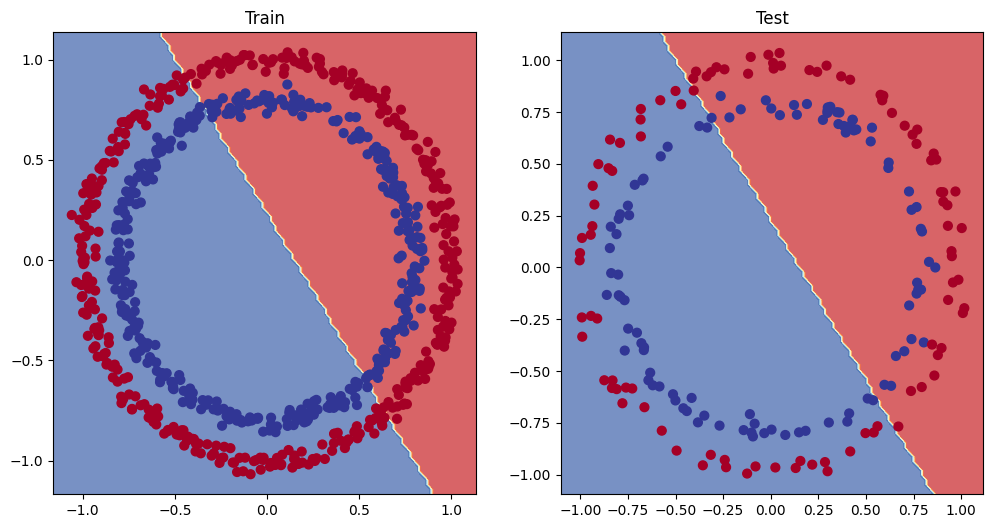

In [23]:

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [24]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [26]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f} | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69396 | Accuracy: 50.88 | Test loss: 0.69261 | Test accuracy: 51.00
Epoch: 100 | Loss: 0.69305 | Accuracy: 50.38 | Test loss: 0.69379 | Test accuracy: 48.00
Epoch: 200 | Loss: 0.69299 | Accuracy: 51.12 | Test loss: 0.69437 | Test accuracy: 46.00
Epoch: 300 | Loss: 0.69298 | Accuracy: 51.62 | Test loss: 0.69458 | Test accuracy: 45.00
Epoch: 400 | Loss: 0.69298 | Accuracy: 51.12 | Test loss: 0.69465 | Test accuracy: 46.00
Epoch: 500 | Loss: 0.69298 | Accuracy: 51.00 | Test loss: 0.69467 | Test accuracy: 46.00
Epoch: 600 | Loss: 0.69298 | Accuracy: 51.00 | Test loss: 0.69468 | Test accuracy: 46.00
Epoch: 700 | Loss: 0.69298 | Accuracy: 51.00 | Test loss: 0.69468 | Test accuracy: 46.00
Epoch: 800 | Loss: 0.69298 | Accuracy: 51.00 | Test loss: 0.69468 | Test accuracy: 46.00
Epoch: 900 | Loss: 0.69298 | Accuracy: 51.00 | Test loss: 0.69468 | Test accuracy: 46.00


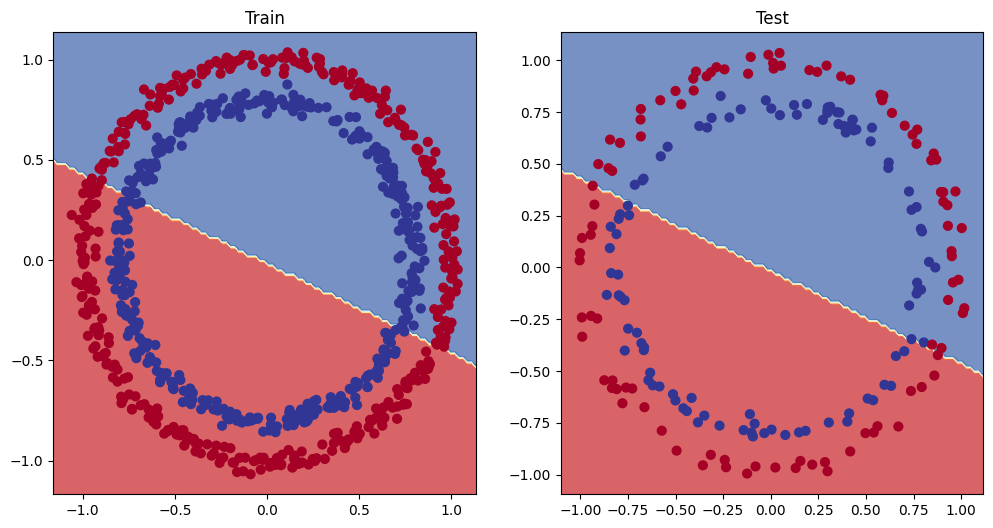

In [27]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [28]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [29]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


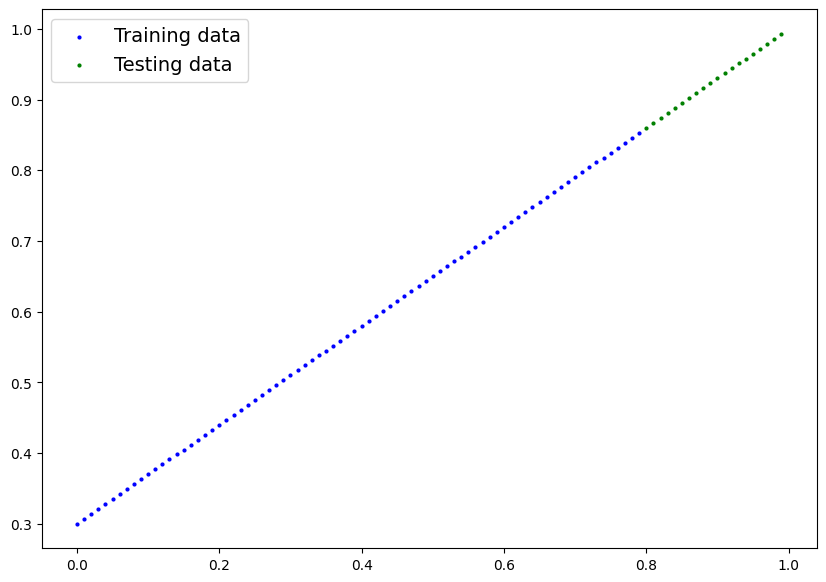

In [30]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [31]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

In [32]:
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [35]:
torch.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  model_2.train()

  y_pred = model_2(X_train_regression)

  loss = loss_fn(y_pred, y_train_regression)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05600, Test loss: 0.01425
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


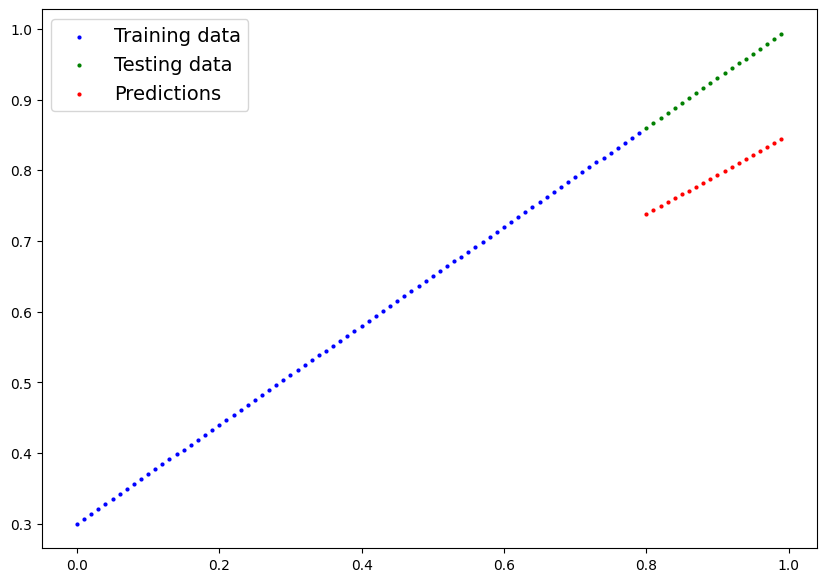

In [36]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

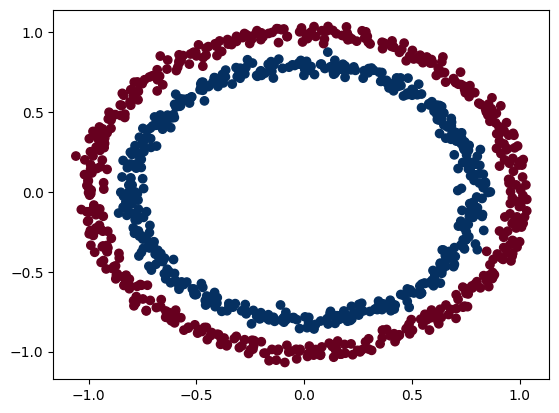

In [37]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [38]:
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [43]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [44]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [45]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}")

Epoch: 0 | Loss: 0.70683, Accuracy: 50.00% | Test Loss: 0.70463, Test Accuracy: 50.00
Epoch: 100 | Loss: 0.69301, Accuracy: 49.75% | Test Loss: 0.69122, Test Accuracy: 54.00
Epoch: 200 | Loss: 0.69129, Accuracy: 50.75% | Test Loss: 0.68961, Test Accuracy: 56.00
Epoch: 300 | Loss: 0.68996, Accuracy: 51.38% | Test Loss: 0.68847, Test Accuracy: 56.00
Epoch: 400 | Loss: 0.68842, Accuracy: 52.50% | Test Loss: 0.68704, Test Accuracy: 56.50
Epoch: 500 | Loss: 0.68640, Accuracy: 52.62% | Test Loss: 0.68518, Test Accuracy: 55.50
Epoch: 600 | Loss: 0.68360, Accuracy: 53.37% | Test Loss: 0.68279, Test Accuracy: 56.00
Epoch: 700 | Loss: 0.67949, Accuracy: 61.88% | Test Loss: 0.67972, Test Accuracy: 61.00
Epoch: 800 | Loss: 0.67328, Accuracy: 63.88% | Test Loss: 0.67545, Test Accuracy: 58.50
Epoch: 900 | Loss: 0.66395, Accuracy: 66.88% | Test Loss: 0.66929, Test Accuracy: 61.00


In [46]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 0., 0., 1., 1., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

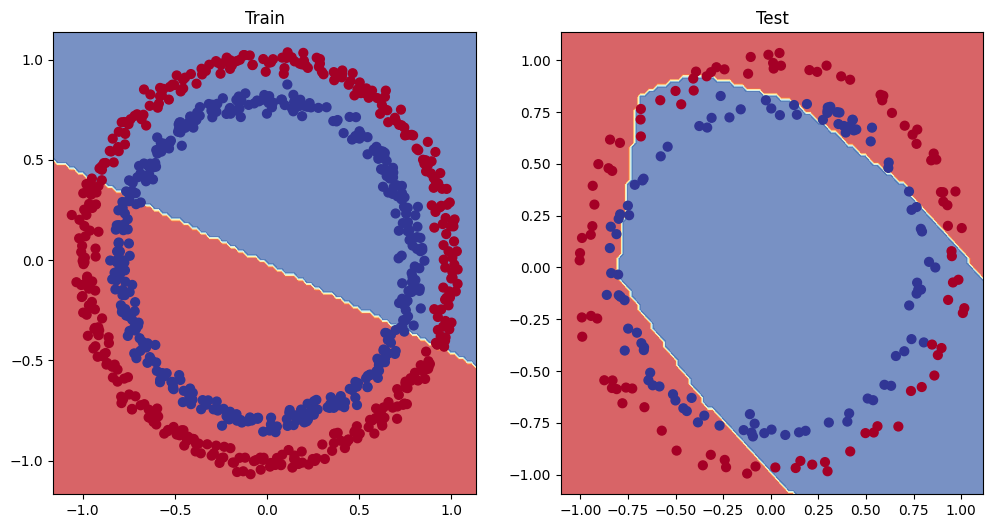

In [47]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

In [48]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

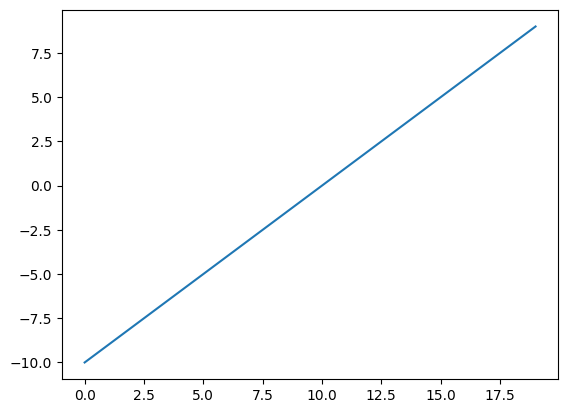

In [49]:
plt.plot(A)

In [50]:
def relu(x):
  return torch.maximum(torch.tensor(0), x)

In [51]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

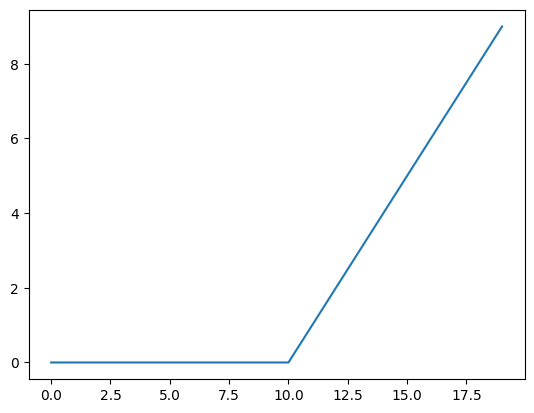

In [53]:
plt.plot(relu(A))

In [54]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

In [55]:
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

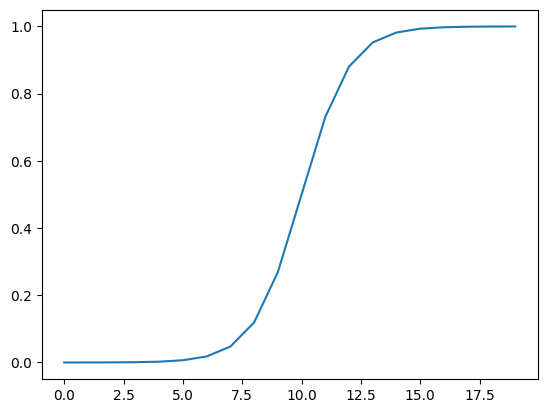

In [56]:
plt.plot(sigmoid(A))

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


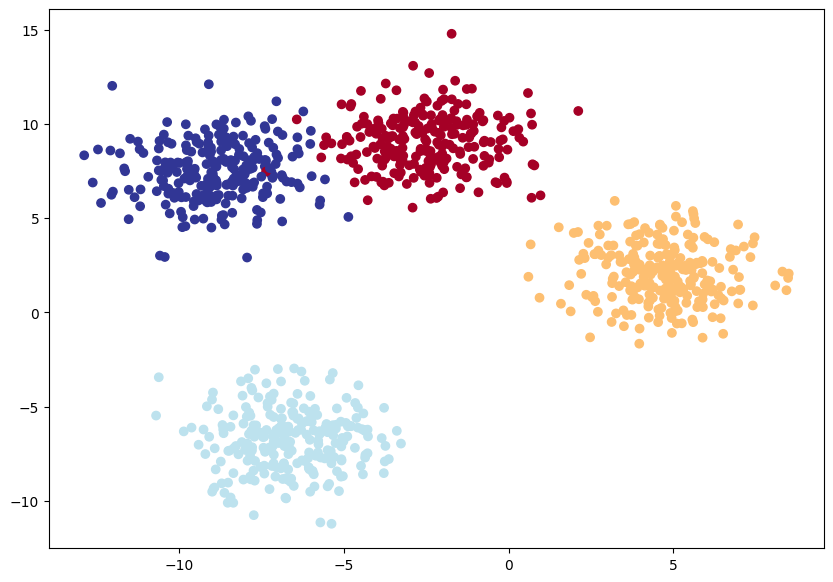

In [57]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [63]:
from torch import nn
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [64]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [65]:
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.8696, -0.7083, -0.3200,  0.5513],
        [-0.1989, -2.0320,  0.4267, -1.2864],
        [-0.9819, -0.0741,  1.0288, -1.7247],
        [-0.6449, -0.4877,  0.7777, -1.4029],
        [-0.2937, -1.7872,  0.4998, -1.3371]], grad_fn=<SliceBackward0>)

In [66]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [68]:
y_logits = model_4(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.8161, -0.8846, -0.2847,  0.4252],
        [-0.9359, -2.0669,  0.9583, -2.2816],
        [-0.6742, -0.0694,  0.8067, -1.3123],
        [ 0.6858, -0.5307, -0.1840,  0.3610],
        [ 0.1430, -1.9414,  0.1816, -0.8017]], grad_fn=<SliceBackward0>)
tensor([[0.4563, 0.0833, 0.1518, 0.3087],
        [0.1215, 0.0392, 0.8077, 0.0316],
        [0.1289, 0.2361, 0.5669, 0.0681],
        [0.4102, 0.1215, 0.1719, 0.2964],
        [0.3918, 0.0487, 0.4072, 0.1523]], grad_fn=<SliceBackward0>)


In [69]:
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [70]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.4563, 0.0833, 0.1518, 0.3087], grad_fn=<SelectBackward0>)
tensor(0)


In [72]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}")

Epoch: 0 | Loss: 0.03655, Accuracy: 99.00% | Test Loss: 0.02813, Test Accuracy: 99.50
Epoch: 10 | Loss: 0.03541, Accuracy: 99.00% | Test Loss: 0.02686, Test Accuracy: 99.50
Epoch: 20 | Loss: 0.03449, Accuracy: 99.00% | Test Loss: 0.02580, Test Accuracy: 99.50
Epoch: 30 | Loss: 0.03373, Accuracy: 99.00% | Test Loss: 0.02491, Test Accuracy: 99.50
Epoch: 40 | Loss: 0.03309, Accuracy: 99.00% | Test Loss: 0.02416, Test Accuracy: 99.50
Epoch: 50 | Loss: 0.03255, Accuracy: 99.00% | Test Loss: 0.02350, Test Accuracy: 99.50
Epoch: 60 | Loss: 0.03209, Accuracy: 99.00% | Test Loss: 0.02293, Test Accuracy: 99.50
Epoch: 70 | Loss: 0.03169, Accuracy: 99.00% | Test Loss: 0.02242, Test Accuracy: 99.50
Epoch: 80 | Loss: 0.03134, Accuracy: 99.00% | Test Loss: 0.02197, Test Accuracy: 99.50
Epoch: 90 | Loss: 0.03104, Accuracy: 99.00% | Test Loss: 0.02157, Test Accuracy: 99.50


In [73]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[ 10.8160,  18.4742, -11.1837,  -5.3175],
        [ -0.5159, -22.6841,  -2.0014,   6.4095],
        [-16.3363, -28.9563,  17.3191,   7.5383],
        [  5.7240,  12.3998,  -5.4803,  -3.7465],
        [ 12.2573,   6.7708, -14.5029,  -1.7651],
        [ -1.3044, -27.8671,  -1.6570,   7.9161],
        [-15.1535, -23.2651,  16.5379,   5.8987],
        [  8.6126,  -1.0820, -10.8656,   0.4031],
        [-19.2262, -38.6734,  19.7598,  10.2969],
        [  9.7653,   1.7412, -11.9729,  -0.3837]])

In [76]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

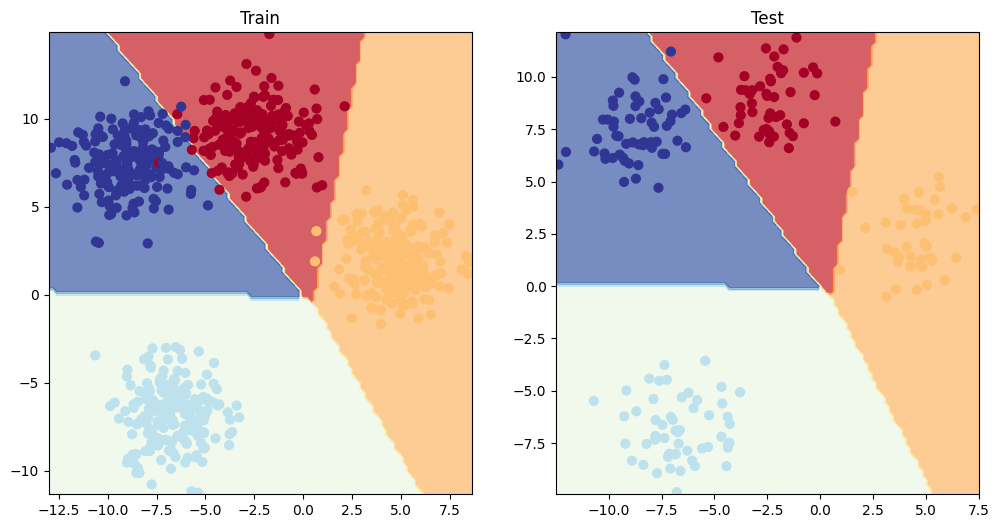

In [77]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [78]:
try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics
  from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950)